In [ ]:
import numpy as np
import pyJuTrack as jt
import matplotlib.pyplot as plt

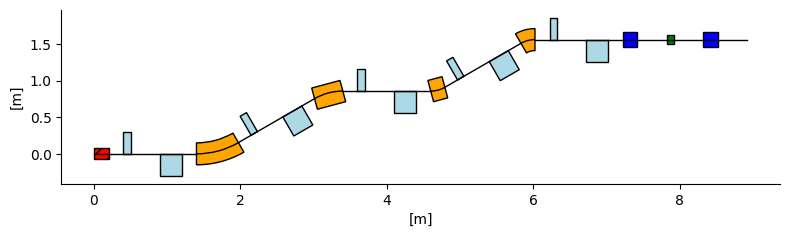

In [2]:
# Plot a lattice with random elements in JuTrack
D1 = jt.DRIFT("D1", 0.2)
Q1 = jt.QUAD("Q1", length=0.1, k1=29.6)
Q2 = jt.QUAD("Q2", length=0.3, k1=-29.6)
D2 = jt.DRIFT("D2", 0.4)
D3 = jt.DRIFT("D3", 0.2)
S1 = jt.KSEXT("S1", length=0.2, k2=0.0)
O1 = jt.KOCT("O1", length=0.1, k3=0.0)
B1 = jt.SBEND("B1", length=0.6, angle=np.pi/6)
B2 = jt.RBEND("B2", length=0.4, angle=-np.pi/6)
B3 = jt.RBEND("B3", length=0.2, angle=np.pi/6)
B4 = jt.SBEND("B4", length=0.2, angle=-np.pi/6)
RF = jt.RFCA("RF", length=0.2, volt=3.42*8.5e6, freq=591e6)

# Build beamline
line = [RF, D1, Q1, D2, Q2, D3, B1, D1, Q1, D2, Q2, D3,
        B2, D1, Q1, D2, Q2, D3, B3, D1, Q1, D2, Q2, D3,
        B4, D1, Q1, D2, Q2, D3, S1, D2, O1, D2, S1, D2]

lattice = jt.Lattice(line)
jt.plot_lattice(line, 0.3, True, savepath=None)

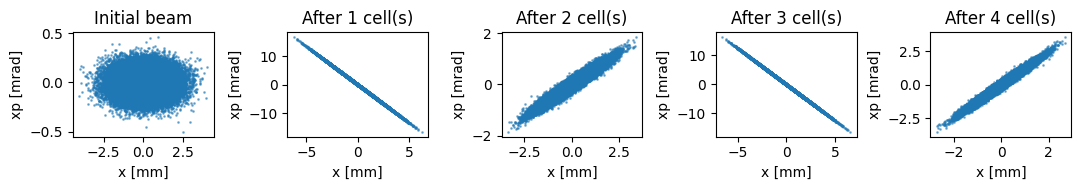

In [3]:
# particle tracking simulation
num_particles = 50000
rin = np.zeros((num_particles, 6))
rin[:, 0] = np.random.normal(0, 1e-3, num_particles)  # x [m]
rin[:, 1] = np.random.normal(0, 1e-4, num_particles)  # xp [rad]

D1 = jt.DRIFT("D1", 0.2)
Q1 = jt.QUAD("Q1", length=0.1, k1=-29.6)
D2 = jt.DRIFT("D2", 0.4)
Q2 = jt.QUAD("Q2", length=0.1, k1=29.6)
D3 = jt.DRIFT("D3", 0.2)
line = jt.Lattice([D1, Q1, D2, Q2, D3])

beam = jt.Beam(rin)


plt.figure(figsize=(11, 2))
plt.subplot(1, 5, 1)
plt.scatter(beam.r[:, 0]*1e3, beam.r[:, 1]*1e3, s=1, alpha=0.5)
plt.xlabel('x [mm]')
plt.ylabel('xp [mrad]')
plt.title('Initial beam')
for i in range(4):
    jt.linepass(line, beam)
    plt.subplot(1, 5, i+2)
    plt.scatter(beam.r[:, 0]*1e3, beam.r[:, 1]*1e3, s=1, alpha=0.5)
    plt.xlabel('x [mm]')
    plt.ylabel('xp [mrad]')
    plt.title(f'After {i+1} cell(s)')

plt.tight_layout()
plt.show()

Found 8 SDM and 8 SFM sextupoles
Found 112 MARKERs. The RDTs will be computed at these locations.

Initial strengths: SDM k2 = -17.00, SFM k2 = 15.00

Starting optimization...

Note: The first iteration will be slower due to Julia's Just-In-Time (JIT) compilation.
You can avoid this overhead by precompiling your code or creating a custom sysimage.
Learn more at https://julialang.github.io/PackageCompiler.jl/stable/.

Iter   0: obj = 5.855357e+03, x = [ -17.06,  +14.96], grad = [+5.82e+01, +4.15e+01]
Iter   1: obj = 5.850288e+03, x = [ -17.12,  +14.92], grad = [+5.75e+01, +4.09e+01]
Iter   2: obj = 5.845351e+03, x = [ -17.17,  +14.88], grad = [+5.68e+01, +4.03e+01]
Iter  10: obj = 5.809928e+03, x = [ -17.60,  +14.57], grad = [+5.20e+01, +3.61e+01]
Iter  20: obj = 5.773571e+03, x = [ -18.10,  +14.24], grad = [+4.75e+01, +3.19e+01]
Iter  30: obj = 5.743556e+03, x = [ -18.55,  +13.94], grad = [+4.39e+01, +2.84e+01]
Iter  40: obj = 5.718246e+03, x = [ -18.97,  +13.67], grad = [+4.09e+01, +2

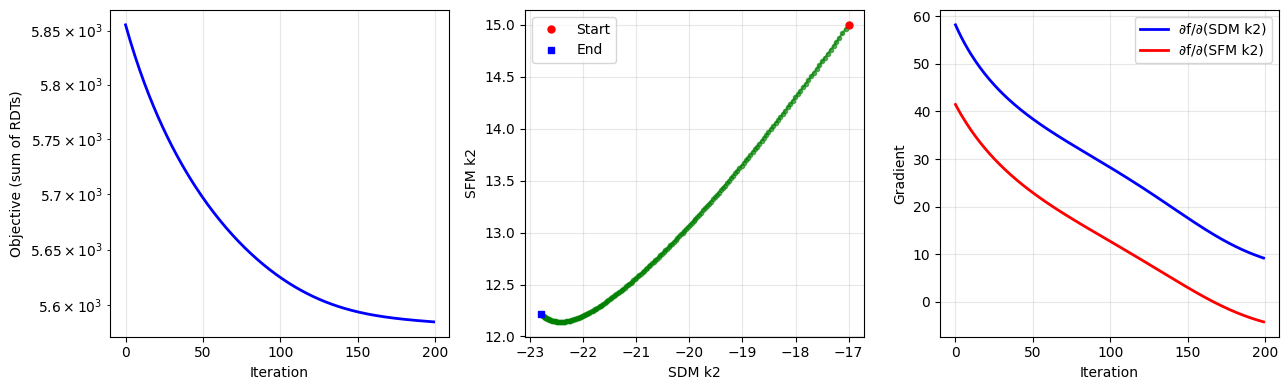

In [ ]:
"""
Demonstration of Resonance Driving Terms (RDTs) optimization using JuTrack's automatic differentiation.
Objective:      Minimize sum of RDTs (h21000, h10110, h30000, h10200, h10020) in SPEAR3 lattice.
Tuning knobs:   Sextupole strengths (SDM and SFM) in SPEAR3 lattice.
"""

jt.set_tps_dim(2) # two variables: SDM k2 and SFM k2

# Load SPEAR3 lattice (written in Julia)
jt.include("../src/demo/SPEAR3/spear3.jl")
ring = jt.Lattice(jt.call_julia("spear3"))

sdm_idx = jt.findelem(ring, name="SDM")
sfm_idx = jt.findelem(ring, name="SFM")
print(f"Found {len(sdm_idx)} SDM and {len(sfm_idx)} SFM sextupoles")

idx_marker = jt.findelem(ring, element_type=jt.element_types.MARKER)
print(f"Found {len(idx_marker)} MARKERs. The RDTs will be computed at these locations.")

ring_tpsa = jt.Number2TPSAD(ring)


def objective(x):
    """
    Pure Python objective function.
    
    Args:
        x: DTPSAD Vector [sdm_k2, sfm_k2]
    
    Returns:
        Sum of RDT terms (h21000, h10110, h30000, h10200, h10020)
    """
    x1 = x[0]  
    x2 = x[1]  
    
    for i in sdm_idx:
        elem = ring_tpsa[i-1]
        elem.k2 = x1
        elem.PolynomB[2] = x1
    
    for i in sfm_idx:
        elem = ring_tpsa[i-1]
        elem.k2 = x2
        elem.PolynomB[2] = x2
    
    dlist, tune = jt.computeRDT(ring_tpsa, idx_marker, E0=3e9, m0=jt.m_e)
    
    tot_21000 = jt.DTPSAD(0.0)
    tot_10110 = jt.DTPSAD(0.0)
    tot_30000 = jt.DTPSAD(0.0)
    tot_10200 = jt.DTPSAD(0.0)
    tot_10020 = jt.DTPSAD(0.0)
    
    for i in range(len(dlist)):
        tot_21000 += dlist[i].h21000[0] 
        tot_10110 += dlist[i].h10110[0]
        tot_30000 += dlist[i].h30000[0]
        tot_10200 += dlist[i].h10200[0]
        tot_10020 += dlist[i].h10020[0]
    
    return tot_21000 + tot_10110 + tot_30000 + tot_10200 + tot_10020

# Initial values
x = np.array([-17.0, 15.0])
print(f"\nInitial strengths: SDM k2 = {x[0]:.2f}, SFM k2 = {x[1]:.2f}")
print("\nStarting optimization...")
print(
    "\nNote: The first iteration will be slower due to Julia's Just-In-Time (JIT) compilation.\n"
    "You can avoid this overhead by precompiling your code or creating a custom sysimage.\n"
    "Learn more at https://julialang.github.io/PackageCompiler.jl/stable/.\n"
)

learning_rate = 0.001
num_iterations = 200

x_history = [x.copy()]
obj_history = []
grad_history = []

# do gradient descent optimization
for i in range(num_iterations):
    grad, obj_val = jt.Gradient(objective, x, return_value=True)
    
    obj_history.append(obj_val)
    grad_history.append(grad.copy())
    
    x = x - learning_rate * grad
    x_history.append(x.copy())
    
    if i % 10 == 0 or i < 3:
        print(f"Iter {i:3d}: obj = {obj_val:.6e}, x = [{x[0]:+7.2f}, {x[1]:+7.2f}], "
              f"grad = [{grad[0]:+.2e}, {grad[1]:+.2e}]")

print(f"  Initial objective: {obj_history[0]:.6e}")
print(f"  Final objective:   {obj_history[-1]:.6e}")
print(f"  Reduction:         {(1 - obj_history[-1]/obj_history[0])*100:.1f}%")
print(f"  Final SDM k2:      {x[0]:.2f}")
print(f"  Final SFM k2:      {x[1]:.2f}")


fig, axes = plt.subplots(1, 3, figsize=(13, 4))
ax = axes[0]
ax.semilogy(obj_history, 'b-', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective (sum of RDTs)')
ax.grid(True, alpha=0.3)

ax = axes[1]
x_arr = np.array(x_history)
ax.plot(x_arr[:, 0], x_arr[:, 1], 'g-o', markersize=3, alpha=0.6)
ax.plot(x_arr[0, 0], x_arr[0, 1], 'ro', markersize=5, label='Start')
ax.plot(x_arr[-1, 0], x_arr[-1, 1], 'bs', markersize=5, label='End')
ax.set_xlabel('SDM k2')
ax.set_ylabel('SFM k2')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
grad_arr = np.array(grad_history)
ax.plot(grad_arr[:, 0], 'b-', label='∂f/∂(SDM k2)', linewidth=2)
ax.plot(grad_arr[:, 1], 'r-', label='∂f/∂(SFM k2)', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Gradient')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rdt_optimization.png', dpi=150, bbox_inches='tight')
print("Saved plot to 'rdt_optimization.png'")

plt.show()